## Supervised LDA

Latent Dirichlet Allocation (LDA) is an unsupervised topic model that represents each document as a mixture of topics, where a topic is a distribution over words. The objective is to learn the shared topic distributions and their proportions for each document. However, it is often desirable to associate a quantity of interest with each document known as a response variable, this could be the quality of a report or a five star rating for a movie review or a number of times an article is downloaded given its contents. Supervised LDA is designed to jointly learn the topics and the response variable associated with each document. The graphical model of supervised LDA is shown below.

<img src=".\figures\sLDA_gm.png">

LDA assumes a bag of words model in which the words are exchangeable and as a result sentence structure is not preserved and only the word counts matter. The LDA associates each word $x_{i,d}$ with a topic label $z_{i,d} \in \{1,...,K\}$. Each document is associated with topic proportions $\theta_d$ that could be used to measure document similarity. The topics $\beta_k$ represented by a Dirichlet distribution are shared across all documents. The hyper-parameters $\alpha$ and $\eta$ capture our prior knowledge of topic mixtures and topics, e.g. from past on-line training of the model. Finally, $y_d$ is the response variable that represents a score associated with each document. It is modelled as a regression between global coefficients $w$ and a histogram of topics $\bar{z}$ present in a document. Assuming a Gaussian distribution, $y_d$ can be expressed as follows:

\begin{eqnarray}
    y_d &\sim& N(w_1 \bar{z}_1 + ... + w_k \bar{z}_k, \sigma^{2}) \\
    \bar{z} &=& \frac{1}{N} \sum_{n=1}^{N} z_n
\end{eqnarray}
where $z_n$ is a one-hot encoded topic assignment vector of size $1\times K$. In other words, $\bar{z}$ is a normalized histogram of topics associated with a document: $\bar{z} = \mathrm{hist}(z_{i,d}, bins=K)$.


Having described the graphical model, we can use PyMC to infer the latent variables. In the training phase, the response variable and the words are observed and we are learning the topics $\beta_k$, topic proportions $\theta_d$ and the regression coefficients $w$. We'll be training the model on movie reviews, where each review is associated with a score from $-2$ to $+2$.

In [23]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

import re
import pymc as pm
from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(0)

In [25]:
train_corpus = ["exploitative and largely devoid of the depth or sophistication ",
                "simplistic silly and tedious",
                "it's so laddish and juvenile only teenage boys could possibly find it funny",
                "it shows that some studios firmly believe that people have lost the ability to think",
                "our culture is headed down the toilet with the ferocity of a frozen burrito",
                "offers that rare combination of entertainment and education",
                "the film provides some great insight",
                "this is a film well worth seeing",
                "a masterpiece four years in the making",
                "offers a breath of the fresh air of true sophistication"]
test_corpus =  ["this is a really positive review, great film"]
train_response = np.array([3, 1, 3, 2, 1, 5, 4, 4, 5, 5]) - 3

In [26]:
#LDA parameters
num_features = 1000  #vocabulary size
num_topics = 4       #fixed for LDA

In [27]:
#compute tf-idf (equivalent to count-vectorizer followed by tf-idf transformer)
#count-vectorizer produces term-document matrix tf-idf scales tf counts by log N/nt 
#(N:total num of docs, nt: number of docs in which the word occurs)
#if float (proportion of docs): min_df < nt/N  < max_df, if int: refers to count nt, e.g. min_df = 2
tfidf = TfidfVectorizer(max_features = num_features, max_df=0.95, min_df=0, stop_words = 'english')

In [28]:
#generate tf-idf term-document matrix
A_tfidf_sp = tfidf.fit_transform(train_corpus)  #size D x V

print "number of docs: %d" %A_tfidf_sp.shape[0]
print "dictionary size: %d" %A_tfidf_sp.shape[1]

#tf-idf dictionary    
tfidf_dict = tfidf.get_feature_names()

number of docs: 10
dictionary size: 46


In [29]:
K = num_topics # number of topics
V = A_tfidf_sp.shape[1] # number of words
D = A_tfidf_sp.shape[0] # number of documents
    
data = A_tfidf_sp.toarray()

In [30]:
#Supervised LDA Graphical Model
Wd = [len(doc) for doc in data]        
alpha = np.ones(K)
beta = np.ones(V)

theta = pm.Container([pm.CompletedDirichlet("theta_%s" % i, pm.Dirichlet("ptheta_%s" % i, theta=alpha)) for i in range(D)])
phi = pm.Container([pm.CompletedDirichlet("phi_%s" % k, pm.Dirichlet("pphi_%s" % k, theta=beta)) for k in range(K)])    
    
z = pm.Container([pm.Categorical('z_%s' % d, p = theta[d], size=Wd[d], value=np.random.randint(K, size=Wd[d])) for d in range(D)])
   
@pm.deterministic
def zbar(z=z):    
    zbar_list = []
    for i in range(len(z)):
        hist, bin_edges = np.histogram(z[i], bins=K)
        zbar_list.append(hist / float(np.sum(hist)))                
    return pm.Container(zbar_list)

eta = pm.Container([pm.Normal("eta_%s" % k, mu=0, tau=1.0/10**2) for k in range(K)])
y_tau = pm.Gamma("tau", alpha=0.1, beta=0.1)
    
@pm.deterministic
def y_mu(eta=eta, zbar=zbar):
    y_mu_list = []
    for i in range(len(zbar)):
        y_mu_list.append(np.dot(eta, zbar[i]))
    return pm.Container(y_mu_list)
            
#response likelihood
y = pm.Container([pm.Normal("y_%s" % d, mu=y_mu[d], tau=y_tau, value=train_response[d], observed=True) for d in range(D)])
    
# cannot use p=phi[z[d][i]] here since phi is an ordinary list while z[d][i] is stochastic
w = pm.Container([pm.Categorical("w_%i_%i" % (d,i), p = pm.Lambda('phi_z_%i_%i' % (d,i), lambda z=z[d][i], phi=phi: phi[z]),
                  value=data[d][i], observed=True) for d in range(D) for i in range(Wd[d])])


Let's infer the latent variables using the Metropolis sampler:

In [31]:
model = pm.Model([theta, phi, z, eta, y_tau, y, w])
mcmc = pm.MCMC(model)
mcmc.sample(iter=1000, burn=100, thin=2)

 [-----------------100%-----------------] 1000 of 1000 complete in 5.7 sec

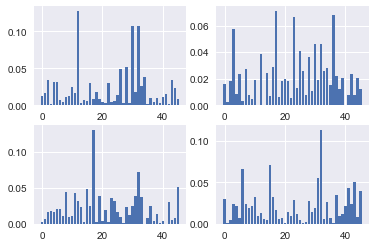

In [32]:
#visualize topics    
phi0_samples = np.squeeze(mcmc.trace('phi_0')[:])
phi1_samples = np.squeeze(mcmc.trace('phi_1')[:])
phi2_samples = np.squeeze(mcmc.trace('phi_2')[:])
phi3_samples = np.squeeze(mcmc.trace('phi_3')[:])
ax = plt.subplot(221)
plt.bar(np.arange(V), phi0_samples[-1,:])
ax = plt.subplot(222)
plt.bar(np.arange(V), phi1_samples[-1,:])
ax = plt.subplot(223)
plt.bar(np.arange(V), phi2_samples[-1,:])
ax = plt.subplot(224)
plt.bar(np.arange(V), phi3_samples[-1,:])
plt.show()

Let's now predict the movie rating for a new document, our test corpus: "this is a really positive review, great film". We are expecting to get  a review close to $+2$. In order to predict our response variable, we'll be using the topics $\beta_k$ and the regression weights $w$ learned during training.

In [33]:
#New Document Prediction
T_tfidf_sp = tfidf.transform(test_corpus)   #size Dtest x V    
Dtest = T_tfidf_sp.shape[0] # number of test documents
    
data_test = T_tfidf_sp.toarray()

In [34]:
#Supervised LDA Graphical Model
Wd_t = [len(doc) for doc in data_test]        
alpha = np.ones(K)
beta = np.ones(V)

theta_t = pm.Container([pm.CompletedDirichlet("theta_t_%s" % i, pm.Dirichlet("ptheta_t_%s" % i, theta=alpha)) for i in range(Dtest)])    
z_t = pm.Container([pm.Categorical('z_t_%s' % d, p = theta_t[d], size=Wd_t[d], value=np.random.randint(K, size=Wd_t[d])) for d in range(Dtest)])
    
@pm.deterministic
def zbar_t(z=z_t):
    zbar_list = []
    for i in range(len(z)):
        hist, bin_edges = np.histogram(z[i], bins=K)
        zbar_list.append(hist / float(np.sum(hist)))                
    return pm.Container(zbar_list)
    
@pm.deterministic
def y_mu_t(eta=eta, zbar=zbar_t):
    y_mu_list = []
    for i in range(len(zbar)):
        y_mu_list.append(np.dot(eta, zbar[i]))
    return pm.Container(y_mu_list)
            
#response prediction
y_t = pm.Container([pm.Normal("y_t_%s" % d, mu=y_mu_t[d], tau=y_tau) for d in range(Dtest)])
   
# cannot use p=phi[z[d][i]] here since phi is an ordinary list while z[d][i] is stochastic
w_t = pm.Container([pm.Categorical("w_t_%i_%i" % (d,i), p = pm.Lambda('phi_z_t_%i_%i' % (d,i), lambda z=z_t[d][i], phi=phi: phi[z]),
                    value=data_test[d][i], observed=True) for d in range(Dtest) for i in range(Wd_t[d])])


Let's run the Metropolis sampler to obtain posterior distribution over our latent variables.

In [35]:
model_test = pm.Model([theta_t, z_t, zbar_t, y_t, w_t])
mcmc_test = pm.MCMC(model_test)
mcmc_test.sample(iter=1000, burn=100, thin=2)

 [-----------------100%-----------------] 1000 of 1000 complete in 4.0 sec

Plotting y_t_0


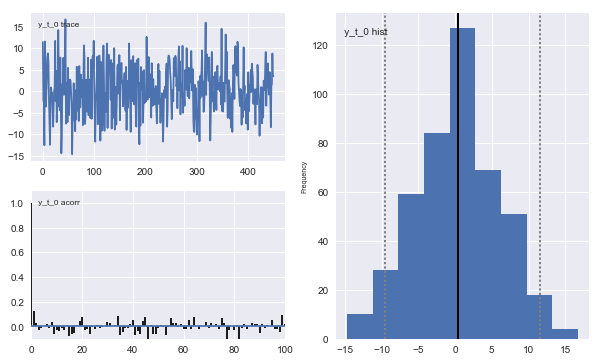

In [36]:
#generate plots
pm.Matplot.plot(mcmc_test.trace('y_t_0'))

From the trace plot of our response variable we can see that we got a positive prediction with a mean close to $1$ and high variance. Increasing the vocabulary size and the number of words per document should help reduce the variance. We can also see low autocorrelation between the samples indicating that each sample is informative.